# Developer Salary in China 全国程序员工资调查
我在4月1日到3日之间，抓取了某招聘网站的软件和互联网类招聘数据40万条，其中通过程序判断为程序员的14万条。地域方面，我选择了24个主要城市。

In [1]:
import pandas as pd
import db
import inspect
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np
%matplotlib inline

In [3]:
conn=db.get_conn()
data_original=pd.read_sql(sql="select * from _201904 where monthly_salary>0 and monthly_salary<15", con=conn)
conn.close()

In [4]:
error_job_ids=['104660258','104142922','108434795','101357291','106253516','110368302','111391233','108665401','109277048'
                  ,'73857191','108584955','102824950','102824949','111391233','110884556']
data=data_original[~data_original.job_id.isin(error_job_ids)]

In [5]:
del data['publish_date']
del data['published_on_weekend']
del data['title']
del data['company_title']
del data['company_description']
del data['job_description']
del data['job_id']

# Unilateral Stats 总体统计

有数据可知，程序员向一线城市集中的趋势非常明显。

According to the statistics, significant amount of developers are in the first tier cities.

In [6]:
salary_mean=data.monthly_salary.mean()*10000
salary_median=data.monthly_salary.median()*10000
q=np.quantile(data.monthly_salary,[0.025,0.975])*10000
print('2019年中国大陆一二线城市程序员的平均工资为{:.0f}元，工资中位数为{:.0f}元，其中95%的人的工资位于{:.0f}到{:.0f}元之间。'
      .format(salary_mean, salary_median, q[0], q[1]))

2019年中国大陆一二线城市程序员的平均工资为13756元，工资中位数为12500元，其中95%的人的工资位于3750到33333元之间。


In [7]:
print('In 2019, Developers in China earn {:.0f} Yuan as average, '
      'the median is {:.0f} Yuan, 95% of them earn between {:.0f} and {:.0f} Yuan.'
      .format(salary_mean, salary_median, q[0], q[1]))

In 2019, Developers in China earn 13756 Yuan as average, the median is 12500 Yuan, 95% of them earn between 3750 and 33333 Yuan.


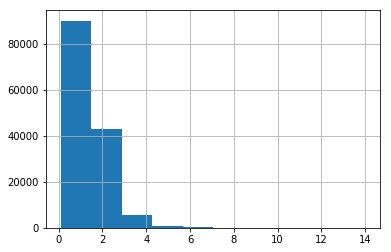

In [8]:
data.monthly_salary.hist()

It does not look like normal distribution.

In [9]:
from scipy import stats

In [10]:
stats.normaltest(data.monthly_salary)

NormaltestResult(statistic=80485.89395778668, pvalue=0.0)

null hypothesis: x comes from a normal distribution
    
p=0

The null hypothesis can be rejected

conclusion: data is not normally distributed.

Zoom in

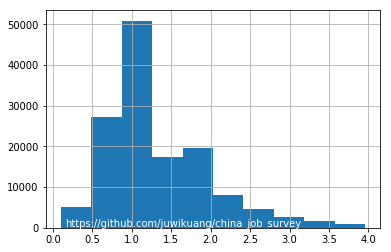

In [13]:
data[data.monthly_salary<4].monthly_salary.hist()
plt.annotate('https://github.com/juwikuang/china_job_survey', xy=(0,0), xytext=(0.15, 500), color='white')
plt.show()

## Role 角色

In [14]:
def get_sub_stats(data, prefix):
    
    features = [feature for feature in data.columns if feature.startswith(prefix)]
    salary_mean=[]
    salary_median=[]
    count=[]
    for feature in features:
        salary_mean.append(data[data[feature]==1].monthly_salary.mean()*10000)
        salary_median.append(data[data[feature]==1].monthly_salary.median()*10000)
        count.append(data[data[feature]==1].shape[0])
    sub_data=pd.DataFrame()
    sub_data[prefix]=[f.replace(prefix,'') for f in features]
    sub_data['salary_mean']=salary_mean
    sub_data['salary_median']=salary_median
    sub_data['head_count']=count
    sub_data['percentage']=count/np.sum(count)
    sub_data=sub_data.sort_values(by='salary_mean', ascending=False)

    return sub_data

In [15]:
def add_category_column(data, prefix):
    prefix_=prefix+"_"
    features = [feature for feature in data.columns if feature.startswith(prefix)]
    data.loc[:,prefix]=['']*data.shape[0]
    for feature in features:
        data.loc[data[feature]==1,prefix]=feature.replace(prefix_,'')
    return data

In [16]:
data_career=get_sub_stats(data,'career_')
data_career.style.format({"percentage":"{:.2%}"})

,career_,salary_mean,salary_median,head_count,percentage
1,architect,21490.6,20000,6233,4.36%
0,algorithm,20312,18000,15821,11.06%
3,spider,13876.9,12500,297,0.21%
2,software_engineer,12817.3,12500,120746,84.38%


有表可知，架构师的工资平均为2.1万，算法工程师为2万，普通程序员为1万3。


In [17]:
career_architect_salary=data[data.career_architect==1].monthly_salary
career_algorithm_salary=data[data.career_algorithm==1].monthly_salary
career_software_engineer_salary=data[data.career_software_engineer==1].monthly_salary
stats.f_oneway(career_algorithm_salary, career_software_engineer_salary)

F_onewayResult(statistic=15108.459348816918, pvalue=0.0)

In [18]:
stats.f_oneway(career_architect_salary, career_algorithm_salary)

F_onewayResult(statistic=50.85401453755663, pvalue=1.0257032259318573e-12)

统计表面，架构师，算法工程师，普通程序员之间的平均工资差异是显著的。

# 编程语言

In [20]:
data_pl=get_sub_stats(data,'pl_')
data_pl.sort_values(by='head_count',ascending=False).style.format({"percentage":"{:.2%}"})

,pl_,salary_mean,salary_median,head_count,percentage
7,java,14155.7,12500,53327,29.28%
2,cpp,15869.1,14000,29281,16.08%
8,javascript,12274.7,11500,27483,15.09%
1,c_sharp,12008.1,11500,19954,10.96%
16,python,17751.1,15000,14946,8.21%
4,go,17567.8,15000,12630,6.94%
15,php,13163.2,12000,9457,5.19%
12,matlab,17720.6,16000,2691,1.48%
11,lua,16210.1,15000,2327,1.28%
20,swift,14246.1,12500,1515,0.83%


数据显示，haskell才是最赚钱的编程语言。python是主流语言里面最赚钱的，比java的工资多了3000元！vb是最不赚钱的了。其中，最赚钱的编程语言和最不赚钱的，工资居然差了2倍。所以，要选好编程语言呀！

# 教育

In [21]:
data_edu=get_sub_stats(data,'edu_')
data_edu.style.format({"percentage":"{:.2%}"})

,edu_,salary_mean,salary_median,head_count,percentage
5,phd,29591.5,25000,174,0.15%
3,master,20689.4,18000,3591,3.10%
1,bachelor,15020.8,12500,72031,62.14%
0,associate,11137.1,10000,39624,34.18%
4,middle_school,9396.55,7000,58,0.05%
2,high_school,8333.78,7000,448,0.39%


大专，本科，硕士，博士的平均工资分别是12828，16840，23084，30308。中位数分别是12500， 15000，21000， 29000。

In [22]:
salary_phd=data[data.edu_phd==1].monthly_salary * 10000
salary_master=data[data.edu_master==1].monthly_salary * 10000
salary_bachelor=data[data.edu_bachelor==1].monthly_salary * 10000
salary_associate=data[data.edu_associate==1].monthly_salary * 10000

In [23]:
print('大专，本科，硕士，博士的平均工资分别是{:.0f}，{:.0f}，{:.0f}，{:.0f}。中位数分别是{:.0f}， {:.0f}，{:.0f}， {:.0f}。'.format(
    salary_associate.mean(),salary_bachelor.mean(),salary_master.mean(),salary_phd.mean(),
    salary_associate.median(),salary_bachelor.median(),salary_master.median(),salary_phd.median()))

大专，本科，硕士，博士的平均工资分别是11137，15021，20689，29591。中位数分别是10000， 12500，18000， 25000。


In [24]:
stats.f_oneway(salary_phd, salary_master)

F_onewayResult(statistic=99.52151746106234, pvalue=3.7529701049822114e-23)

In [25]:
stats.f_oneway(salary_master, salary_bachelor)

F_onewayResult(statistic=1688.374319851099, pvalue=0.0)

In [26]:
stats.f_oneway(salary_bachelor, salary_associate)

F_onewayResult(statistic=7542.405799147878, pvalue=0.0)

经过Oneway Anova Test，证明从大专到博士，学历每提高一级，工资都有显著的提高。

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


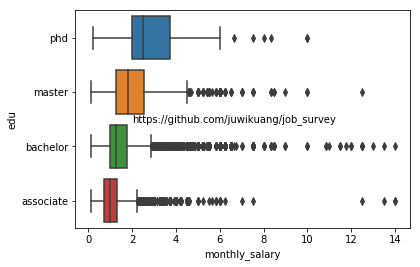

In [27]:
data=add_category_column(data,'edu')
order=['phd','master','bachelor','associate']
a=sns.boxplot(y='edu',x='monthly_salary',order=order,data=data[data.edu.isin(order)], orient='h')
plt.annotate('https://github.com/juwikuang/job_survey', xy=(0.5,1.5), xytext=(2, 1.55))
plt.show()

# 工作经验 Working Experience

In [28]:
data_experience=get_sub_stats(data,'experience_')
data_experience.style.format({"percentage":"{:.2%}"})

,experience_,salary_mean,salary_median,head_count,percentage
0,10,29943.1,27500,472,0.34%
3,5_10,20636,19000,17281,12.38%
2,3_5,15022,12500,40163,28.78%
4,no,11874.3,10416.7,38124,27.32%
1,1_3,11328.5,10416.7,43526,31.19%


In [29]:
salary_we_10=data[data.experience_10==1].monthly_salary * 10000
salary_we_5_10=data[data.experience_5_10==1].monthly_salary * 10000
salary_we_3_5=data[data.experience_3_5==1].monthly_salary * 10000
salary_we_1_3=data[data.experience_1_3==1].monthly_salary * 10000
salary_we_no=data[data.experience_no==1].monthly_salary * 10000

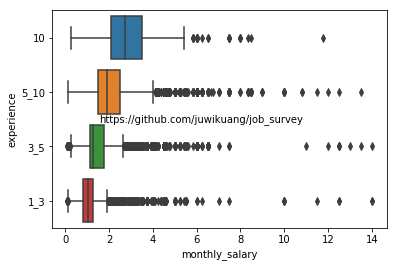

In [30]:
data=add_category_column(data,'experience')
order=['10','5_10','3_5','1_3']
sns.boxplot(y='experience',x='monthly_salary',order=order,data=data[data.experience.isin(order)], orient='h')
plt.annotate('https://github.com/juwikuang/job_survey', xy=(1.5,1.5), xytext=(1.55, 1.55))
plt.show()

数据显示，工资会随着工作经验的增长而增长。不过，我感觉那些招十年工作经验的，基本上都是架构师等职位。如果你的工作经验是一年的工作经验重复十次，应该拿不到那么高的工资。这个以后我还会仔细分析。

# 城市 City

In [31]:
data_city=get_sub_stats(data,'city_')
data_city.style.format({"percentage":"{:.2%}","salary_mean":"{:.0f}","salary_median":"{:.0f}"})

,city_,salary_mean,salary_median,head_count,percentage
0,beijing,17453,15000,13823,9.90%
17,shanghai,16626,15000,25888,18.55%
19,shenzhen,15631,14000,20757,14.87%
9,hangzhou,14977,12500,8690,6.23%
8,guangzhou,13032,12000,17068,12.23%
14,nanjing,12874,12500,7091,5.08%
3,chengdu,11896,11500,7028,5.04%
6,dongguan,11353,10417,1632,1.17%
22,xian,11075,10000,3833,2.75%
21,wuhan,11074,10417,8027,5.75%


程序员收入最高的城市分别为：北京，上海，深圳，广州

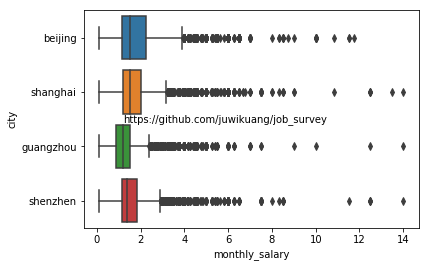

In [32]:
data=add_category_column(data,'city')
#order=['shenzhen','guangzhou','shanghai','beijing']
order=['beijing','shanghai','guangzhou','shenzhen']

sns.boxplot(y='city',x='monthly_salary',order=order,data=data[data.city.isin(order)], orient='h')
plt.annotate('https://github.com/juwikuang/job_survey', xy=(0.5,1.5), xytext=(1.2, 1.55))
plt.show()

In [33]:
data_city.sort_values(by='head_count', ascending=False).style.format({"percentage":"{:.2%}","salary_mean":"{:.0f}","salary_median":"{:.0f}"})

,city_,salary_mean,salary_median,head_count,percentage
17,shanghai,16626,15000,25888,18.55%
19,shenzhen,15631,14000,20757,14.87%
8,guangzhou,13032,12000,17068,12.23%
0,beijing,17453,15000,13823,9.90%
9,hangzhou,14977,12500,8690,6.23%
21,wuhan,11074,10417,8027,5.75%
14,nanjing,12874,12500,7091,5.08%
3,chengdu,11896,11500,7028,5.04%
22,xian,11075,10000,3833,2.75%
2,changsha,10847,10000,3354,2.40%


<BarContainer object of 24 artists>

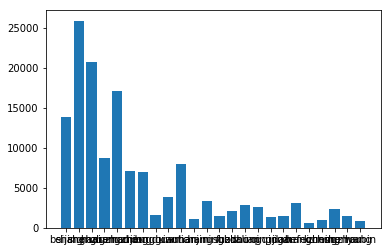

In [34]:
plt.bar(data_city.city_, data_city.head_count)

# 公司 Company

## 公司性质 Company Type

In [35]:
data_company_type=get_sub_stats(data,'company_type_')
data_company_type.style.format({"percentage":"{:.2%}","salary_mean":"{:.0f}","salary_median":"{:.0f}"})

,company_type_,salary_mean,salary_median,head_count,percentage
9,us_eu,16553,15000,5289,4.07%
2,foreign_rep,16158,15000,108,0.08%
3,listed,14597,12500,12400,9.55%
7,startup,14408,12500,3221,2.48%
0,foreign,13904,12500,5830,4.49%
8,state,13819,12500,7478,5.76%
5,private,13359,12500,94473,72.79%
1,foreign_gov,13347,11667,18,0.01%
6,public_institution,13137,11667,841,0.65%
4,non_profit,10167,10000,139,0.11%


us_eu是欧美外企，startup是创业公司，listed是上市公司，state是国企，private是私企，foreign是非欧美外企，其他不足1000个样本的不管了。

In [36]:
salary_us_eu=data[data.company_type_us_eu==1].monthly_salary
salary_startup=data[data.company_type_startup==1].monthly_salary
salary_listed=data[data.company_type_listed==1].monthly_salary

In [37]:
stats.f_oneway(salary_us_eu,salary_startup)

F_onewayResult(statistic=119.77184496249959, pvalue=1.0851072054106644e-27)

In [38]:
stats.f_oneway(salary_us_eu,salary_listed)

F_onewayResult(statistic=230.18298018979925, pvalue=1.1499907691025375e-51)

由上报可知，欧美外企的工资显著高于其他企业。比创业公司和上司公司足足高了2000元呀。要努力学好英语呀！

顺便做个广告，大家如果想通过看美剧或者看英文书提高英语，可以上我的网站，美剧单词网。里面会把你不懂的单词列出来，你再去听美剧，听英语有声书（网站提供），就能听懂了。

https://www.tvshowwords.com/


## 公司规模 Company Size

In [39]:
data_company_size=get_sub_stats(data,'company_size_')
data_company_size.style.format({"percentage":"{:.2%}","salary_mean":"{:.0f}","salary_median":"{:.0f}"})

,company_size_,salary_mean,salary_median,head_count,percentage
0,10000,19133,15000,5705,4.10%
4,5000_10000,15322,13500,2753,1.98%
1,1000_5000,15248,13500,17578,12.64%
5,500_1000,14714,12500,14103,10.14%
2,150_500,13620,12500,32541,23.40%
6,50_150,12902,12000,42630,30.65%
3,50,12288,11500,23762,17.09%


公司越大，工资越高

## 行业 Industry

In [40]:
data_industry=get_sub_stats(data,'industry_')
data_industry.style.format({"percentage":"{:.2%}","salary_mean":"{:.0f}","salary_median":"{:.0f}"})

,industry_,salary_mean,salary_median,head_count,percentage
4,finance,15934,14583,5586,3.33%
2,edu,15066,12500,10084,6.01%
6,logistic,14341,12500,2268,1.35%
9,service,14236,12500,1432,0.85%
1,computer,13756,12500,119772,71.33%
10,trade,13682,12500,11629,6.93%
5,gov,13413,12500,3510,2.09%
7,medical,12950,12500,4309,2.57%
8,realestate,12855,12000,3122,1.86%
3,energy,12729,12000,3178,1.89%


金融业果然是工资最高的。